In [90]:
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import copy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import contractions
import random
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix
import math
import seaborn as sbn
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to C:\Users\Samyak
[nltk_data]     Jain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Samyak
[nltk_data]     Jain\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Samyak
[nltk_data]     Jain\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Samyak
[nltk_data]     Jain\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [91]:
class_names = ["comp.graphics", "sci.med", "talk.politics.misc", "rec.sport.hockey", "sci.space"] #the five classes we have
class_labels = [0, 1, 2, 3, 4] #assigning an integer label to each class
class_name_to_label = {class_names[i]:i for i in range(len(class_names))} #class name to class label mapping
class_label_to_name = {i:class_names[i] for i in range(len(class_names))} #class label to class name mapping
data_folder = "../data/20_newsgroups/20_newsgroups"

In [92]:
def splitData(class_names, data_folder, train_ratio):
    '''
        This function is used for splitting the data into train and test parts according to the train-test ratio.
    '''
    class_wise_data = [] # A list of dictionaries to hold the training and testing documents for each class.
    for i in range(len(class_names)):
        class_dir = data_folder + '/' + class_names[i] #directory for that class in the data
        file_names = os.listdir(class_dir) #file names in that class directory
        n_docs_class = len(file_names) #number of docs in the class
        shuffled_docs = random.sample(file_names, n_docs_class) #shuffle the documents in the class so that when splitting we take the documents randomly into train and test sets and not sequentially.
        n_train = int(train_ratio * n_docs_class) #number of train set docs
        n_test = n_docs_class - n_train #number of test set docs
        train_docs_class = shuffled_docs[:n_train] #the documents in the training set
        test_docs_class = shuffled_docs[n_train:] #the documents in the testing set
        class_wise_data.append({'train' : train_docs_class, 'test' : test_docs_class}) #Appending the training and testing doc lists as a dictionary to the total class-wise dataset list
    return class_wise_data

In [93]:
def check_alnum(tok):
    '''
        Remove non-alphanumeric characters from a string
    '''

    tok = ''.join(ch for ch in tok if ch.isalnum() == True)
    return tok

def remove_punct(tok):
    '''
        Remove the punctuation in token
    '''
    punctuations = string.punctuation
    tok = ''.join(ch for ch in tok if ch not in punctuations)
    return tok

def remove_blank_space(tok):
    '''
        Remove the spaces in token
    '''
    tok = ''.join(ch for ch in tok if ch != ' ')
    return tok
def preprocess(text):
    '''
        Preprocess the file text and converting to word tokens
        Input: string File text
        Returns file_tokens, word tokens for the pre processed text
    '''
    #converting text to lowercase
    text = text.lower()

    #Fixing the contractions
    text = contractions.fix(text)

    #Performing word tokenization
    all_tokens = word_tokenize(text)

    #Omitting all the non-alphanumeric characters in tokens
    all_tokens = [check_alnum(tok) for tok in all_tokens]

    #removing stopwords
    stop_words = list(set(stopwords.words('english')))
    all_tokens = [tok for tok in all_tokens if tok not in stop_words]

    #removing punctations if any remain
    toks_no_punct = []
    for tok in all_tokens:
        ctok = remove_punct(tok)
        if(ctok != ""):
            toks_no_punct.append(ctok)

    #removing spaces in any remain
    cleaned_toks = []
    for tok in toks_no_punct:
        ctok = remove_blank_space(tok)
        if(ctok != ""):
            cleaned_toks.append(ctok)
    
    #stemming
    stemmer = nltk.PorterStemmer()
    final_tokens = [stemmer.stem(tok) for tok in cleaned_toks]

    # final_tokens = [tok for tok in cleaned_toks]

    return final_tokens


In [94]:
def process_data(class_wise_data, class_labels):
    '''
        This function takes the input of class_wise_data which is a list of dicts containing the training and testing set documents 
        belonging to each class. It returns three dictionaries: class_wise_tokens - nested dictionary with the outer dictionary having the
        key as the class_label and the value as another dictionary that contains the tokens for each preprocessed document in the training and testing 
        set of that class ; class_wise_train_unique_tokens - A dictionary with key as the class_label and value is a list of all the unique tokens present 
        in the documents of that particular class; class_wise_train_tfs -  A dictionary with key as the class_label and value is a a dictionary which has the
        term frequencies of all the unique terms in that class.
    '''
    class_wise_train_unique_tokens = {} #A dictionary with key as the class_label and value is a list of all the unique tokens present in the documents of that particular class
    class_wise_tokens = {i: {'train' : [], 'test': []} for i in range(5)} #nested dictionary with the outer dictionary having the key as the class_label and the value as another dictionary that contains the tokens for each preprocessed document in the training and testing  set of that class
    class_wise_train_tfs = {} #A dictionary with key as the class_label and value is a a dictionary which has the term frequencies of all the unique terms in that class
    for label in tqdm(class_labels): #loop over all the class_labels
        class_train_data = class_wise_data[label]['train'] #training set docs of that class
        class_test_data = class_wise_data[label]['test'] #testing set docs of that class
        class_train_tokens = [] #the document wise tokens for the training set docs in that class
        for doc in class_train_data:
            f = open(data_folder + '/' + class_label_to_name[label] + '/' + doc, encoding='utf-8', errors='ignore')
            ftxt_unproc = f.read()
            doc_toks = preprocess(ftxt_unproc) #preprocess the document to get tokens for that document
            class_train_tokens.append(doc_toks)
        class_wise_tokens[label]['train'] = class_train_tokens
        class_test_tokens = [] #the document wise tokens for the testing set docs in that class
        for doc in class_test_data:
            f = open(data_folder + '/' + class_label_to_name[label] + '/' + doc, encoding='utf-8', errors='ignore')
            ftxt_unproc = f.read()
            doc_toks = preprocess(ftxt_unproc) #preprocess the document to get tokens for that document
            class_test_tokens.append(doc_toks)
        class_wise_tokens[label]['test'] = class_test_tokens

        all_class_train_tokens = [] #all the tokens across all the training documents of the aparticular class
        for doc_toks in class_train_tokens: #loop over all training doc's token lists
            for tok in doc_toks:
                all_class_train_tokens.append(tok)
        class_tfs = dict(Counter(all_class_train_tokens)) #the term frequency for the terms in all the training document combined in that particular class.
        #Note that here, term frequency of a term in a class is number of occurrences of a term in all documents (here train) of a particular class
        class_wise_train_tfs[label] = class_tfs
        class_wise_train_unique_tokens[label] = list(set(all_class_train_tokens)) #the unique tokens present across all the training docs combined of that particular class
    return class_wise_tokens, class_wise_train_unique_tokens, class_wise_train_tfs

def compute_icf(class_wise_unq_toks):
    '''
        This function computes the icf all the tokens present int the training set documents.
    '''
    all_class_toks = {} # Dictionary which holds the tokens present in train docs over all classes as keys. The value for each key is a list of all the classes the token/term appears in.
    for label in class_labels: #iterate over all classes
        for tok in class_wise_unq_toks[label]: #iterate over all the unique tokens of each class
            if(tok in all_class_toks.keys()): #if token is present in the all_class_toks
                all_class_toks[tok].append(label) #append current class' label to its list
            else:
                all_class_toks[tok] = [label] #else initialize its list
    num_classes = len(class_labels) #number of classes
    term_icf = {} #dict to hold the icf for each term in the training documents over all classes
    for term in all_class_toks.keys():
        assert (len(all_class_toks[term]) > 0 and len(all_class_toks[term]) <= 5)
        class_frequency = len(all_class_toks[term]) #class frequency is the length of the list for a token which contains the class labels for the classes that token is present in.
        term_icf[term] = math.log10(num_classes / class_frequency) #icf value of a term is ratio of total number of classes to the number of classes the term appears in
    return term_icf

In [95]:
def feature_selection(term_icfs, class_wise_train_unique_tokens, class_wise_train_tfs, k):
    '''
        Implements the feature selection algorithm to select top k features from each class. Returns a dictionary with the key as class labels 
        and value is a list of top-k features of that class. Also returns a set which is the union of top-k features from each class i.e
        it is the effective vocabulary.
        Note: Feature selection is to be done over only the training dataset.
    '''
    class_wise_top_k = {} #dictionary holding class-wise top k features
    total_feature_set = set() #set holding the union of top-k features for each class i.e effective vocabulary
    for label in class_labels: #loop over the all the labels
        class_unique_toks = class_wise_train_unique_tokens[label] #unique tokens present in the training set of that class
        class_tfs = class_wise_train_tfs[label] #term frequencies of the terms present in the training set of that class
        tf_icf_score = {} #tf_icf_score for the terms in that class
        for tok in class_unique_toks: #iterate over all the unique tokens present in a particular class
            tf_icf_tok = class_tfs[tok] * term_icfs[tok] #tf-icf score is the product of the term frequency of a term in the training set of the class
            tf_icf_score[tok] = tf_icf_tok
        sorted_tf_icf = dict(sorted(tf_icf_score.items(), key=lambda item: item[1], reverse=True)) #sort the tf-icf scores of the terms in descing order
        top_k_class_features = list(sorted_tf_icf.keys())[:k] #select the top k terms with highest tf-icf score in the class
        class_wise_top_k[label] = top_k_class_features #these are the top-k features of that particular class
        total_feature_set.update(top_k_class_features) #update the combined feature set (effective vocab) with these top k features of this class
    return class_wise_top_k, total_feature_set
        

In [96]:
def featurize_data(class_wise_tokens, feature_set):
    '''
        Featurizing the dataset i.e making the train_x, train_y, test_x, test_y according to the features we have selected.
    '''

    #Basically through this process we make the training X and Y, testing X and Y having those features that we have selected through the feature selection process

    train_x = [] #holds the samples(feature values) for the training set
    train_y = [] #holds the class labels corresponding to the samples of the training set
    test_x = [] #holds the samples(feature values) for the testing set
    test_y = [] #holds the class labels corresponding to the samples of the testing set

    for label in class_labels: #iterate over all the class labels
        
        class_train_doc = class_wise_tokens[label]['train'] #document-wise tokens for the documents in the training set of the particular class
        class_test_doc = class_wise_tokens[label]['test'] #document-wise tokens for the documents in the testing set of the particular class

        for doc_toks in class_train_doc: #iterate over the list of document-wise tokens for the documents in the training set of the particular class
            doc_feature = []
            doc_tfs = dict(Counter(doc_toks)) #Term frequencies in a document for the tokens in the training doc
            for i, tok in enumerate(feature_set): #iterate over the tokens/words in combined feature set/effective vocab
                if(tok in doc_tfs.keys()): #if the word is present in this training document
                    doc_feature.append(doc_tfs[tok]) #the feature value will be the term frequency of this term in this training document
                else: #if the word is present in this training document
                    doc_feature.append(0) #the feature value will be zero
            train_x.append(doc_feature)
            train_y.append(label)
        
        #repeat the same process for the testing set documents
        for doc_toks in class_test_doc:
            doc_feature = []
            doc_tfs = dict(Counter(doc_toks))
            for i, tok in enumerate(feature_set):
                if(tok in doc_tfs.keys()):
                    doc_feature.append(doc_tfs[tok])
                else:
                    doc_feature.append(0)
            test_x.append(doc_feature)
            test_y.append(label)
    
    return train_x, test_x, train_y, test_y

In [97]:
def train_naive_bayes(train_x, train_y):
    '''
        This function is used for training of the Naive Bayes Model. Returns the prior and class conditional probabilities
    '''
    num_features = len(train_x[0])
    prior_prob = {} #A dictionary to store the prior probabilities of the classes
    conditional_prob = {label:{} for label in class_labels} #dictionary to store the class conditional pro
    class_feature_cum = {label:{feat:0 for feat in range(num_features)} for label in class_labels} #cumulative class-wise stats for each selected feature.
    #this is a nested dictionary where the outer dictionary has key as the class_label and value as another dictionary which stores the frequency of each feature(word) in that class.
    total_class_samples = len(train_y)
    class_wise_count = dict(Counter(train_y)) #class-wise count of samples ie- no. of training sample of each class
    for label in class_labels: #iterate over all class labels
        prior_prob[label] = float(class_wise_count[label]) / float(total_class_samples) #prior probab of class is ratio of the class_samples to the total_number_of_samples
    for i in range(total_class_samples): #this loop constructs the class_feature_cum dictionary which will be used for conditional probability calculation
        sample_label = train_y[i]
        for j in range(num_features):
            class_feature_cum[sample_label][j] += train_x[i][j]
    alpha = 1 #for laplace add one smoothing
    for label in class_labels:
        for feature in range(num_features):
            conditional_prob[label][feature] = float(class_feature_cum[label][feature] + alpha ) / float(sum(class_feature_cum[label].values()) + (num_features*alpha)) #conditional probab of a feature(word) wrt a class is the ratio of number of occurences of that word in that particular class divided by the sum of frequencies of all features(words) wrt that class.
    
    return prior_prob, conditional_prob

def predict_naive_bayes(test_x, prior_prob, conditional_prob):
    '''
        This function is used for calculating the predicitons for a trained Naive Bayes model. Input is the testing set samples and the trained model's
        prior probability and conditional probabilities.
    '''

    #Note: Here instead of calculating the posterior we calculate the log of posterior (doesn't affect the answer because log is increasing function). 
    # This is done to prevent underflow due to multiplication of very small probability values. Thus the multiplication of probabilities effectively transforms to
    # addition of log probabilities.
    predictions = []
    for sample in test_x: #for each sample in the testing set
        posterior_probs = {} #dictionary to hold the posterior probability for each class
        for label in class_labels: #iterate over all the labels
            probab = math.log10(prior_prob[label])  #prior probability part
            for feature in range(len(sample)): #for each feature in feature set
                if(sample[feature] != 0): #if the feature value is non zero i.e the word is present in the testing sample
                    probab += (math.log10(conditional_prob[label][feature]) * sample[feature]) #we add the log conditional probability of that feature 'x' times where 'x' is the frequency of that word in the sample
            posterior_probs[label] = probab
        pred_label = max(posterior_probs, key= lambda x: posterior_probs[x]) #the predicted label is the key value corresponding to maximum posterior probability
        predictions.append(pred_label)
    return predictions

def compute_accuracy(true_y, pred_y):
    '''
        Function to compute accuracy
    '''
    correct = 0
    total = len(true_y)
    for i in range(total):
        if(true_y[i] == pred_y[i]):
            correct += 1
    accuracy = float(correct) / float(total)
    return accuracy

def calculate_confusion_matrix(true_y, pred_y):
    '''
        Function to calculate confusion matrix
    '''
    conf_matrix = np.zeros((len(class_labels), len(class_labels)))
    for i in range(len(true_y)):
        conf_matrix[true_y[i]][pred_y[i]] += 1
    return conf_matrix

def plot_confusion_matrix(conf_matrix, fig_name, save=False):
    plt.figure(figsize=(8,6))
    sbn.heatmap(conf_matrix, annot=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    if(save == True):
        plt.savefig(fig_name, bbox_inches='tight', facecolor='w')
    plt.show()

In [98]:
def run_question3(train_ratio, k):
        
    class_wise_data = splitData(class_names, data_folder, train_ratio)
    print(">> Processing Data")
    class_wise_tokens, class_wise_train_unique_tokens, class_wise_train_tfs = process_data(class_wise_data, class_labels)

    print(">> Computing term ICFs")
    term_icfs = compute_icf(class_wise_train_unique_tokens)

    print(">> Performing feature selection")
    class_wise_top_k, feature_set = feature_selection(term_icfs, class_wise_train_unique_tokens, class_wise_train_tfs, k)

    # print(f"\nAfter selecting top {k} features from each class, Total Feature-set(Vocab) size = {len(feature_set)}\n")
    
    print(">> Featurizing dataset")
    train_x, test_x, train_y, test_y = featurize_data(class_wise_tokens, feature_set)

    print(">> Training Naive Bayes Model")
    prior_prob, conditional_prob = train_naive_bayes(train_x, train_y)

    print(">> Testing Naive Bayes Model")
    predicted_labels = predict_naive_bayes(test_x, prior_prob, conditional_prob)

    accuracy_value = compute_accuracy(test_y, predicted_labels)
    print(f"Accuracy = {accuracy_value * 100}%")
    conf_matrix = calculate_confusion_matrix(test_y, predicted_labels)
    print(f"\nConfusion Matrix: \n{conf_matrix}")

    return accuracy_value, conf_matrix


Value of k (for feature selection) = 60
Class name to label mapping : {'comp.graphics': 0, 'sci.med': 1, 'talk.politics.misc': 2, 'rec.sport.hockey': 3, 'sci.space': 4}


-------------Training set size = 50.0% total data---------------------

>> Processing Data


100%|██████████| 5/5 [00:37<00:00,  7.54s/it]


>> Computing term ICFs
>> Performing feature selection
>> Featurizing dataset
>> Training Naive Bayes Model
>> Testing Naive Bayes Model
Accuracy = 99.11999999999999%

Confusion Matrix: 
[[492.   1.   0.   2.   5.]
 [  4. 495.   1.   0.   0.]
 [  0.   5. 493.   1.   1.]
 [  0.   0.   0. 500.   0.]
 [  1.   0.   1.   0. 498.]]


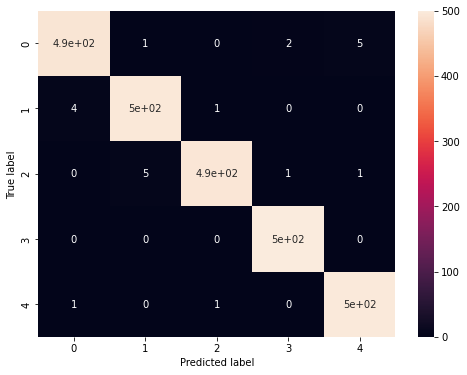


---------------------------------------------------------------

-------------Training set size = 70.0% total data---------------------

>> Processing Data


 80%|████████  | 4/5 [00:30<00:07,  7.64s/it]

In [101]:

train_ratios = [0.5, 0.7, 0.8]
k = int(input("Enter the value of k : "))
print(f"Value of k (for feature selection) = {k}")
print(f"Class name to label mapping : {class_name_to_label}\n")
for i in range(len(train_ratios)):
    # random.seed()
    print(f"\n-------------Training set size = {train_ratios[i] * 100}% total data---------------------\n")
    accuracy, conf_matrix = run_question3(train_ratios[i], k)
    plot_confusion_matrix(conf_matrix, f"conf_matrix_k_{k}_train_{i}.png", save=True)
    print("\n---------------------------------------------------------------")
     